In [1]:
import numpy as np
import matplotlib.pyplot as plt
from onix.units import ureg, Q_
from onix.analysis.fitter import Fitter
from onix.data_tools import get_experiment_data

<h1>Noise estimations</h1>
<h3>Importing measured noise spectrum to integrate.</h3>

In [2]:
data_number = 2785
data = get_experiment_data(data_number)

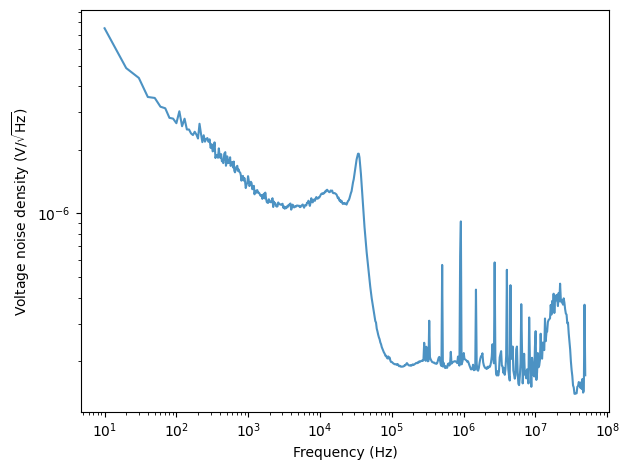

In [3]:
W_V = np.sqrt(data[0]["W_V"])
W_V_freqs = data[0]["f"]
fig, ax = plt.subplots()
ax.plot(W_V_freqs, W_V, alpha=0.8)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Voltage noise density (V/$\\sqrt{\\mathrm{Hz}}$)")
plt.tight_layout()
plt.show()

<h3>Noise integration.</h3>

In [4]:
start_frequency = 1e1
stop_frequency = 100e3 # Hz ( 10 us )

def total_noise(f, W_V, start_frequency, stop_frequency):
    W_V = W_V[np.bitwise_and(f >= start_frequency, f < stop_frequency)]
    f = f[np.bitwise_and(f >= start_frequency, f < stop_frequency)]
    W_P = W_V ** 2 # Proportional to power
    P = np.trapz(W_P, x = f) # Integrate |s(f)|^2 df
    V = np.sqrt(P) # Convert back to voltage
    return V * ureg.V


V_noise = total_noise(W_V_freqs, W_V, start_frequency, stop_frequency)

# V_noise = 1e-8 * np.sqrt(100e3) * ureg.V
print(f"Integrating gives {V_noise:.6f} noise.")

Integrating gives 0.000285 volt noise.


<h3>Parameters to estimate the chasm, antihole, and RF transmission.</h3>

In [5]:
# Params
# V_noise_density = 5e-8 * ureg.V / np.sqrt(1 * ureg.Hz)
# V_freq = 100 * ureg.kHz # 10 us
V_signal = 0.9375 * ureg.V # From pd_model.ipynb assuming 500 uW to photodiode

optical_depth_max = 1.5 # max OD of crystal
fraction_light_in_sideband = 0.3 # fraction of light in sideband of EOM
fraction_pi_pulse = 0.8 # fraction of pi pulse for b a transition

rabi_freq = 2*np.pi*10e3 * ureg.Hz # Rabi frequency
sigma = 30e3 * ureg.Hz # Approximate inhomogeneous broadening spread of a single transition peak 

<h3>Number of probes</h3>

In [6]:
gamma_tot = 500 * ureg.Hz # total decay rate
num_density = 1.3e14 / (1 * ureg.cm) ** 3
crystal_length = 10 * ureg.cm
sig0 = optical_depth_max/(num_density * crystal_length)
print(sig0.to("cm **2"))
# sig0 = 3e-14 * ureg.cm * ureg.cm # scattering cross section
omega0 = 2 * np.pi * 516 * ureg.THz # transition frequency
c = 3e8 * ureg.m/ureg.s # speed of light in vacuum
hbar = 6.63e-34 / (2*np.pi) * ureg.J * ureg.s # h bar
eps0 = 8.854e-12 * ureg.F/ureg.m # electric permitivity
D = np.sqrt(sig0*eps0*c*hbar*gamma_tot/(2*omega0)) # dipole matrix element
print((D.to_base_units()/(1.6e-19 * ureg.C * 5e-11 * ureg.m)).to_base_units())

E = 34 * ureg.V / ureg.cm
rabi_freq = D*E/hbar
print(rabi_freq.to_base_units())

probe_time = 10 * ureg.us
N_probes = int(np.floor((0.1*np.pi/(rabi_freq*probe_time)).to_base_units().magnitude))
print(N_probes)

1.1538461538461538e-15 centimeter ** 2
6.242181639548882e-06 dimensionless
1609.057803583988 / second
19


<h3>Other statistical parameters.</h3>

In [7]:
N_antihole = 4 # Number of datapoints in the antihole
N_offset = 20 # Number of offset measurements
# N_probes = 1 # Number of probes

<h3>Gaussian sampling and fitter functions.</h3>

In [8]:
# To get Vr at specified freq ( sampling from a gaussian )
def specified_val_gaussian(x):
    return np.exp(-(0 - x) ** 2 / (2 * sigma.magnitude **2))

# Function to fit Gaussian
def Gaussian(x, a, mu, sig, c):
    return a * np.exp(-(x-mu)**2 / (2*sig**2)) + c

<h3>Simulating the chasm, antihole, and RF transmission voltages and noise.</h3>

In [9]:
SNR = V_signal/V_noise

Vc = V_signal # chasm
Va = Vc*(1-fraction_light_in_sideband) + Vc*fraction_light_in_sideband*np.exp(-optical_depth_max) # antihole
Va_error = Va/SNR/np.sqrt(N_antihole)/np.sqrt(N_probes)

freqs = np.linspace(-75e3, 75e3, N_offset) # rf frequency offset

diffs = np.zeros(N_offset)
diff_errors = np.zeros(N_offset)
SNRs = np.zeros(N_offset)

def diff_and_errors(freq):
    Vr = Va + (Vc-Va)*0.5*(rabi_freq/(2*np.log(2)*sigma))*fraction_pi_pulse*specified_val_gaussian(freq) # rf
    Vr_error = Vr/SNR/np.sqrt(N_antihole)/np.sqrt(N_probes)
    
    diff = abs(Va - Vr).to("V").magnitude
    diff_error = np.sqrt(Va_error ** 2 + Vr_error ** 2).to("V").magnitude

    return diff, diff_error
    
for i, freq in enumerate(freqs):    
    diff, diff_error = diff_and_errors(freq)
    diffs[i] = diff
    diff_errors[i] = diff_error
    SNRs[i] = diff/diff_error


In [10]:
# Simulating data and fitting to get error

# sampled_diffs = []
# for diff, diff_error in zip(diffs, diff_errors):
#     sampled_diffs.append(np.random.normal(diff, diff_error, 1)[0])

# fitter = Fitter(Gaussian)
# fitter.set_data(freqs, sampled_diffs, diff_errors)
# fitter.set_p0({"a" : 0.2, "mu" : 0, "sig" : sigma.magnitude, "c": 0})
# fitter.fit()

# a = fitter.results["a"]
# mu = fitter.results["mu"]
# sig = fitter.results["sig"]
# c = fitter.results["c"]

# delta_f = fitter.errors["mu"] * ureg.Hz
# print(f"delta f = {delta_f}")

In [11]:
# freqs_fit = np.linspace(-75e3, 75e3, 200)
# plt.plot(freqs_fit, Gaussian(freqs_fit, a, mu, sig, c))
# plt.plot(freqs, sampled_diffs, '.')
# plt.show()

<h3>Resolution from linewidth and SNR.</h3>

In [12]:
# Projecting HWHM error into the center frequency error
FWHM = 2*np.sqrt(2*np.log(2))*sigma
HWHM = (FWHM/2).magnitude
diff_HWHM, diff_error_HWHM = diff_and_errors(HWHM)
delta_f = diff_error_HWHM/diff_HWHM * HWHM/np.sqrt(N_offset) * ureg.Hz
print(f"df = {delta_f:.2f}")

df = 165.74 hertz


<h3>Time to get down to 1 mHz resolution.</h3>

In [13]:
single_measurement_time = 5 * ureg.s # antihole time
time_per_probe = 10 * ureg.us # probe time
single_measurement_time_with_probes = single_measurement_time + N_probes * N_antihole * time_per_probe # total time for antihole + probes
measurement_time = N_offset * single_measurement_time_with_probes # number of measurements * total time per measurement 
delta_f_0 = 1 * ureg.mHz # target resolution

total_measurement_time = measurement_time * (delta_f/delta_f_0)**2
print(f"The time to get to {delta_f:.2f} resolution is: {measurement_time.to('s'):.0f}(s).")
print(f"The time to get to {delta_f_0:.2f} resolution is: {total_measurement_time.to('year')}(s).")

The time to get to 165.74 hertz resolution is: 100 second(s).
The time to get to 1.00 millihertz resolution is: 87056.2605566339 year(s).
